In [ ]:
!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-c

In [ ]:
import typing as tp
from collections import defaultdict, Counter
import json

import torch
import torch.nn as nn
import transformers
from transformers import AutoTokenizer
from mamba_ssm.modules.mamba2_simple import Mamba2Simple
import matplotlib.pyplot as plt
def normalize_attn_mat(attn_mat):
    return (attn_mat - torch.min(attn_mat)) / (torch.max(attn_mat) - torch.min(attn_mat))
from datasets import load_dataset

from torch.utils.data import DataLoader
from feedforward import SwiGLU
from model import LanguageModel
from mha import ModifiedMHA

In [ ]:
SwiGLU_cfg = {'dim': 512, 'dim_inner': 'null', 'drop_rate': 0, 'bias': False}
Mamba_cfg = {'dim': 512, 'd_state': 16*4, 'd_conv': 4, 'expand': 2, "headdim": 4, "A_init_range": (1, 1.1), 'compute_attn': True, "use_mem_eff_path": False}
Attn_cfg = {'embed_dim': 512, "num_heads": 128, 'batch_first': True}

In [ ]:
MODEL_NAME = 'efromomr/mamba_x2_attn'

In [ ]:
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
check_model = LanguageModel.from_pretrained(MODEL_NAME,
                                            layers = [Mamba2Simple, SwiGLU, Mamba2Simple, SwiGLU, ModifiedMHA, SwiGLU],
                                            layer_cfgs = [Mamba_cfg, SwiGLU_cfg, Mamba_cfg, SwiGLU_cfg, Attn_cfg, SwiGLU_cfg], dim=512)
check_model = check_model.eval()

In [ ]:
dataset = load_dataset('eraser-benchmark/movie_rationales', trust_remote_code=True)

README.md:   0%|          | 0.00/6.65k [00:00<?, ?B/s]

movie_rationales.py:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1600 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/199 [00:00<?, ? examples/s]

In [ ]:
with open('sents.json', 'r') as file:
    sents = json.load(file)

In [ ]:
с = Counter([word['pos'] for word in sent for sent in sents])
print({k: v/c.total() for k, v in c.items() if k is not None})

с = Counter([word['synt_tag'] for word in sent for sent in sents])
print({k: v/c.total() for k, v in c.items() if k is not None})

In [ ]:
max_attn_scores = []
for name, module in check_model.named_modules():
      if isinstance(module, ModifiedMHA) or isinstance(module, Mamba2Simple):
        max_attn_scores.append({"layer_type": type(module), 'layer_list': [defaultdict(list) for _ in range(module.attn_matrix.shape[1])]})

In [ ]:
for i, line in enumerate(dataset['test']['review']):
  input_ids = torch.tensor(tokenizer.encode(line))[None, :]
  check_model(input_ids)

  modules_with_attn = []

  for name, module in check_model.named_modules():
      if isinstance(module, ModifiedMHA) or isinstance(module, Mamba2Simple):
        modules_with_attn.append(module)

  for layer_num, mod in enumerate(modules_with_attn):
    for head_num, head in enumerate(mod.attn_matrix[0]):
      head = normalize_attn_mat(head.cpu().detach())
      max_attn_scores[layer_num]['layer_list'][head_num]["from_CLS"].append(sents[i][head[:, 0].argmax()]),
      max_attn_scores[layer_num]['layer_list'][head_num]["to_CLS"].append(sents[i][head[0].argmax()])
      #"max_value": sents[i][(head.argmax() // head.shape[-1], head.argmax() % head.shape[-1])]})

In [ ]:
def head_analysis(head, threashold=0.9, num_texts=199):
  specializations = []
  for key in ['from_CLS', 'to_CLS']:
    for feature in ['pos', 'position', 'synt_tag']:
      c = Counter([value[feature] for value in head[key]])
      rates = {k: v/num_texts for k, v in c.items() if v/num_texts >= threashold and k is not None}
      if rates:
        specializations.append({'key': key, 'feature': feature, 'spec': rates})
  return specializations

In [ ]:
specs = []

for layer_num, layer in enumerate(max_attn_scores):
  for head_num, head in enumerate(layer['layer_list']):
    spec = head_analysis(head)
    if spec:
      specs.append({'layer': layer_num, 'head': head_num, 'spec': spec})

In [ ]:
print(specs)

print(f"Percent of specialized heads: {len(specs) / len(max_attn_scores) * len(max_attn_scores[0]['layer_list'])}")

[{'layer': 0,
  'head': 11,
  'spec': [{'key': 'from_CLS',
    'feature': 'pos',
    'spec': {'CCONJ': 0.9597989949748744}},
   {'key': 'from_CLS',
    'feature': 'synt_tag',
    'spec': {'cc': 0.9597989949748744}}]},
 {'layer': 0,
  'head': 17,
  'spec': [{'key': 'to_CLS',
    'feature': 'pos',
    'spec': {'CCONJ': 0.9748743718592965}},
   {'key': 'to_CLS',
    'feature': 'synt_tag',
    'spec': {'cc': 0.9748743718592965}}]},
 {'layer': 0,
  'head': 19,
  'spec': [{'key': 'to_CLS',
    'feature': 'position',
    'spec': {0: 0.9346733668341709}}]},
 {'layer': 0,
  'head': 93,
  'spec': [{'key': 'to_CLS',
    'feature': 'pos',
    'spec': {'CCONJ': 0.9748743718592965}},
   {'key': 'to_CLS',
    'feature': 'synt_tag',
    'spec': {'cc': 0.9748743718592965}}]},
 {'layer': 0,
  'head': 106,
  'spec': [{'key': 'from_CLS',
    'feature': 'pos',
    'spec': {'CCONJ': 0.949748743718593}},
   {'key': 'from_CLS',
    'feature': 'synt_tag',
    'spec': {'cc': 0.949748743718593}}]}]

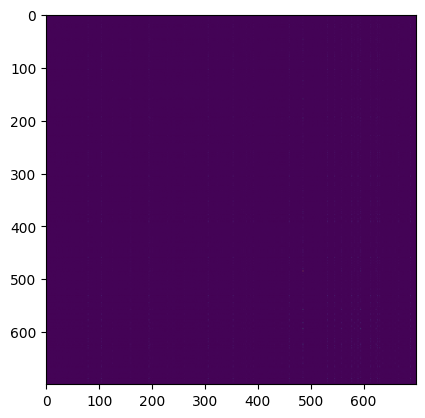

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(normalize_attn_mat(check_model.model[0][1].attn_matrix[0].mean(dim=0).cpu().detach()))